In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [51]:
class DataGenerator:
    def __init__(self, num_samples):
        self.num_samples = num_samples
    
    def generate(self):
        x = torch.unsqueeze(torch.linspace(-10, 10, self.num_samples), dim=1)
        y = x**2 + 5 * x + 2 
        return x, y

In [52]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_func='relu', dropout_rate=0.5):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_size, output_size)

        # Выбор функции активации
        if activation_func == 'relu':
            self.activation = nn.ReLU()
        elif activation_func == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError("Invalid activation function. Use 'relu' or 'tanh'")
    
    def forward(self, x):
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.activation(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [53]:
#обучение модели 
def train_model(model, criterion, optimizer, scheduler, y_train, x_train, y_val, x_val, epochs=1000):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        
        # Прямой проход
        outputs = model(y_train)
        loss = criterion(outputs, x_train)
        
        # Назад и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Обновление learning rate
        scheduler.step()

        train_losses.append(loss.item())

        # Валидация
        model.eval()
        with torch.no_grad():
            val_outputs = model(y_val)
            val_loss = criterion(val_outputs, x_val)
            val_losses.append(val_loss.item())
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

    return train_losses, val_losses

Epoch [100/1000], Train Loss: 15.7580, Val Loss: 14.1367, LR: 0.005000
Epoch [200/1000], Train Loss: 15.6042, Val Loss: 13.9944, LR: 0.002500
Epoch [300/1000], Train Loss: 15.2073, Val Loss: 13.9326, LR: 0.001250
Epoch [400/1000], Train Loss: 15.5715, Val Loss: 13.9419, LR: 0.000625
Epoch [500/1000], Train Loss: 15.5832, Val Loss: 13.9400, LR: 0.000313
Epoch [600/1000], Train Loss: 15.6831, Val Loss: 13.9446, LR: 0.000156
Epoch [700/1000], Train Loss: 15.5761, Val Loss: 13.9330, LR: 0.000078
Epoch [800/1000], Train Loss: 15.9678, Val Loss: 13.9274, LR: 0.000039
Epoch [900/1000], Train Loss: 15.6281, Val Loss: 13.9362, LR: 0.000020
Epoch [1000/1000], Train Loss: 15.4347, Val Loss: 13.9379, LR: 0.000010


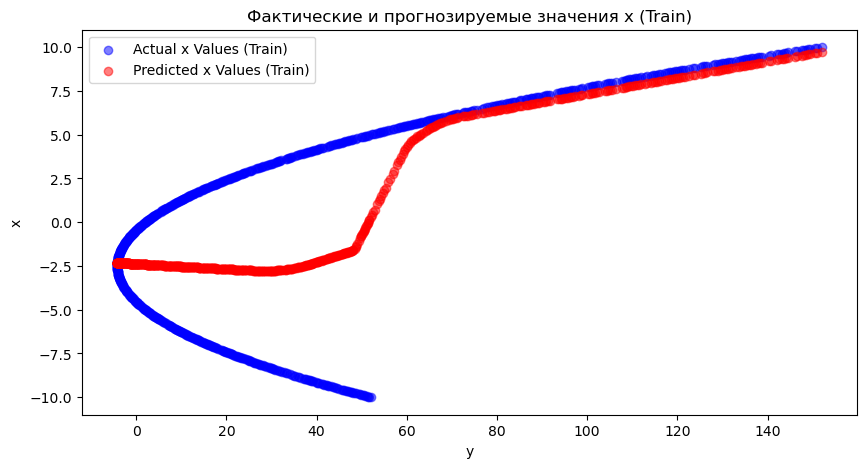

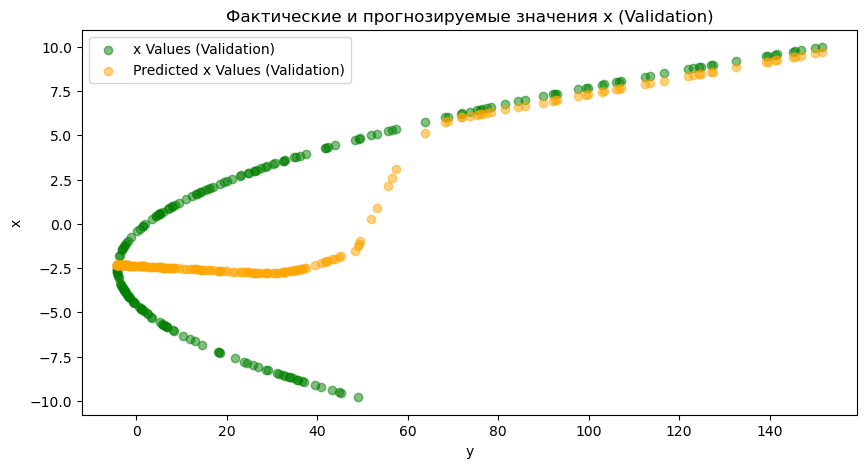

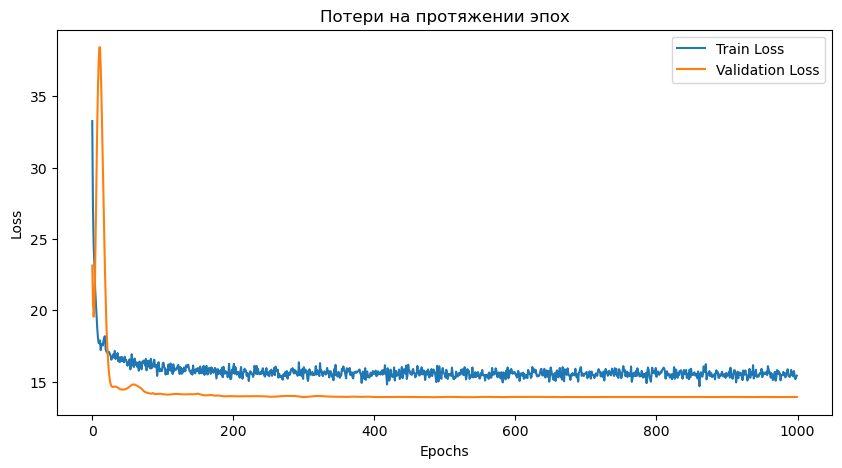

In [54]:
def main():
    data_gen = DataGenerator(num_samples=1000)
    x, y = data_gen.generate()

    # Разделение данных на обучающие и валидационные
    x_train, x_val, y_train, y_val = train_test_split(x.numpy(), y.numpy(), test_size=0.2, random_state=42)

    # Преобразование обратно в тензоры
    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_val = torch.tensor(x_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)

    # Инициализация модели, критерия и оптимизатора
    input_size = 1
    hidden_size = 64
    output_size = 1
    learning_rate = 0.01
    epochs = 1000

    model = MLP(input_size, hidden_size, output_size, activation_func='relu', dropout_rate=0.5)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Создание scheduler для изменения learning rate
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

    # Обучение модели
    train_losses, val_losses = train_model(model, criterion, optimizer, 
                                           scheduler, y_train, x_train, y_val, x_val, epochs)

    # Получение предсказаний
    with torch.no_grad():
        x_val_pred = model(y_val)
        x_train_pred = model(y_train)

    # Визуализация предсказаний для обучающего набора
    plt.figure(figsize=(10, 5))
    plt.scatter(y_train.numpy(), x_train.numpy(), color='blue', label='Actual x Values (Train)', alpha=0.5)
    plt.scatter(y_train.numpy(), x_train_pred.numpy(), color='red', label='Predicted x Values (Train)', alpha=0.5)
    plt.title('Фактические и прогнозируемые значения x (Train)')
    plt.xlabel('y')
    plt.ylabel('x')
    plt.legend()
    plt.show()

    # Визуализация предсказаний для валидационного набора
    plt.figure(figsize=(10, 5))
    plt.scatter(y_val.numpy(), x_val.numpy(), color='green', label='x Values (Validation)', alpha=0.5)
    plt.scatter(y_val.numpy(), x_val_pred.numpy(), color='orange', label='Predicted x Values (Validation)', alpha=0.5)
    plt.title('Фактические и прогнозируемые значения x (Validation)')
    plt.xlabel('y')
    plt.ylabel('x')
    plt.legend()
    plt.show()

    # Визуализация потерь
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Потери на протяжении эпох')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()